In [ ]:

CANDIDATE_NAME = "NitishKhatale"

# Installs (quiet)
!pip -q install gdown scipy reportlab

# Imports & folders
import os, warnings, shutil
warnings.filterwarnings("ignore")
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from IPython.display import display

BASE = Path(".")
CSV_DIR = BASE / "csv_files"
OUT_DIR = BASE / "outputs"
CSV_DIR.mkdir(exist_ok=True); OUT_DIR.mkdir(exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print(f"[saved] {path}")

print("Folders ready:", CSV_DIR, OUT_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:00
Folders ready: csv_files outputs


In [ ]:
# ===== STEP 2: Download OR Upload the two CSVs =====
import gdown
from google.colab import files

# File IDs (from assignment)
HYPERLIQUID_FILE_ID = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
FEARGREED_FILE_ID   = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

hyperliquid_path = CSV_DIR / "hyperliquid_trades.csv"
feargreed_path   = CSV_DIR / "fear_greed.csv"

def try_download(fid, out_path: Path):
    if out_path.exists():
        print("Found:", out_path.name);
        return True
    url = f"https://drive.google.com/uc?id={fid}"
    gdown.download(url, str(out_path), quiet=False)
    return out_path.exists()

ok1 = try_download(HYPERLIQUID_FILE_ID, hyperliquid_path)
ok2 = try_download(FEARGREED_FILE_ID,   feargreed_path)

def ask_upload(prompt, out_path: Path):
    if out_path.exists(): return True
    print(prompt, "→ choose the CSV file")
    up = files.upload()
    if not up: return False
    name = next(iter(up.keys()))
    os.replace(name, str(out_path))
    print("Saved as:", out_path)
    return True

if not ok1: ok1 = ask_upload("📥 Upload Hyperliquid trades CSV", hyperliquid_path)
if not ok2: ok2 = ask_upload("📥 Upload Fear & Greed CSV", feargreed_path)

print("Files present?", hyperliquid_path.exists(), feargreed_path.exists())
if not (hyperliquid_path.exists() and feargreed_path.exists()):
    raise FileNotFoundError("❌ Both CSVs are required. Re-run this cell and upload when prompted.")


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/csv_files/hyperliquid_trades.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 66.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/csv_files/fear_greed.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 76.4MB/s]

Files present? True True


In [ ]:
# ===== STEP 3: Clean + Features + Merge =====
# Load
trades_raw = pd.read_csv(hyperliquid_path)
sent_raw   = pd.read_csv(feargreed_path)

# Clean column names
def clean_cols(df: pd.DataFrame):
    df = df.copy()
    df.columns = (df.columns
                  .str.strip().str.lower()
                  .str.replace(" ", "_", regex=False)
                  .str.replace("-", "_", regex=False))
    return df

trades = clean_cols(trades_raw)
sent   = clean_cols(sent_raw)

# --- Parse trade time -> date (handles text, seconds, or ms) ---
time_col = next((c for c in ["time","timestamp","exec_time","trade_time","datetime","date"] if c in trades.columns), None)
if time_col is None:
    raise ValueError("❌ Trade CSV needs a time/timestamp/date column.")

tc = trades[time_col]
if pd.api.types.is_numeric_dtype(tc):
    # Guess unit: seconds vs milliseconds
    med = tc.dropna().astype(float).abs().median()
    unit = "ms" if med > 1e12 else "s"
    trades[time_col] = pd.to_datetime(tc, unit=unit, errors="coerce", utc=True)
else:
    trades[time_col] = pd.to_datetime(tc, errors="coerce", utc=True)

trades["date"] = pd.to_datetime(trades[time_col]).dt.date

# Numeric conversions (if present)
for c in ["execution_price","price","size","qty","quantity","closedpnl","leverage","start_position"]:
    if c in trades.columns:
        trades[c] = pd.to_numeric(trades[c], errors="coerce")

# Normalize side (optional)
if "side" in trades.columns:
    trades["side"] = trades["side"].astype(str).str.lower().replace({"buy":"long","sell":"short"})

# --- Sentiment cleanup ---
if "date" not in sent.columns:
    for col in sent.columns:
        if col.lower()=="date":
            sent = sent.rename(columns={col:"date"}); break
sent["date"] = pd.to_datetime(sent["date"], errors="coerce").dt.date

class_col = next((c for c in ["classification","class","sentiment"] if c in sent.columns), None)
if class_col is None:
    raise ValueError("❌ Sentiment CSV must include 'Classification' (Fear/Greed).")
sent[class_col] = sent[class_col].astype(str).str.strip().str.lower()
sent["is_greed"] = sent[class_col].map({"greed":1,"fear":0})

# Helper to pick best column available
def pick(df, candidates):
    for c in candidates:
        if c in df.columns: return df[c]
    return None

price = pick(trades, ["execution_price","price"])
size  = pick(trades, ["size","qty","quantity"])
pnl   = pick(trades, ["closedpnl","realized_pnl","pnl"])
lev   = pick(trades, ["leverage"])

# Trade-level features
trades["notional"] = (price.fillna(0) * size.fillna(0)) if (price is not None and size is not None) else np.nan
if pnl is not None:
    trades["is_profitable"] = (pnl > 0).astype(float)

# Daily aggregation
agg = {"notional":"sum"}
if pnl is not None: agg["closedpnl"] = "sum"
if lev is not None: agg["leverage"]  = "mean"
if size is not None: agg["size"]     = "mean"
if "is_profitable" in trades.columns: agg["is_profitable"] = "mean"  # % profitable

daily = (trades
         .groupby("date")
         .agg(agg)
         .rename(columns={"is_profitable":"pct_profitable"})
         .reset_index())
daily["trades_count"] = trades.groupby("date").size().values

# Merge with sentiment
df = pd.merge(daily, sent[["date","is_greed"]], on="date", how="left")
df["sentiment"] = np.where(df["is_greed"]==1, "Greed",
                           np.where(df["is_greed"]==0, "Fear", "Unknown"))

# Save merged CSV
merged_path = CSV_DIR / "daily_behavior_with_sentiment.csv"
df.to_csv(merged_path, index=False)

print("[saved]", merged_path, "| rows:", len(df))
display(df.head(10))


[saved] csv_files/daily_behavior_with_sentiment.csv | rows: 7


,date,notional,trades_count,is_greed,sentiment
0,2023-03-28,0.0,3,1.0,Greed
1,2023-11-14,0.0,1045,1.0,Greed
2,2024-03-09,0.0,6962,NaN,Unknown
3,2024-07-03,0.0,7141,NaN,Unknown
4,2024-10-27,0.0,35241,1.0,Greed
5,2025-02-19,0.0,133871,0.0,Fear
6,2025-06-15,0.0,26961,NaN,Unknown


[saved] outputs/notional_vs_sentiment.png


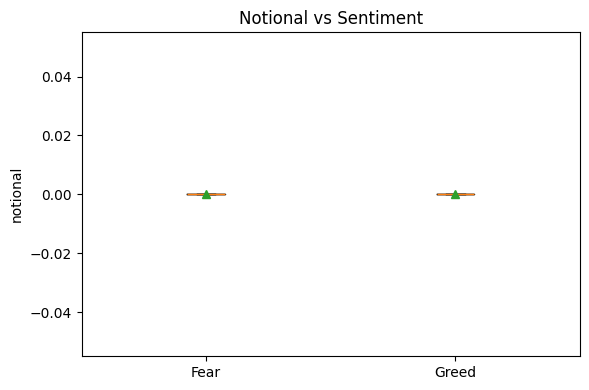

[saved] outputs/trades_count_vs_sentiment.png


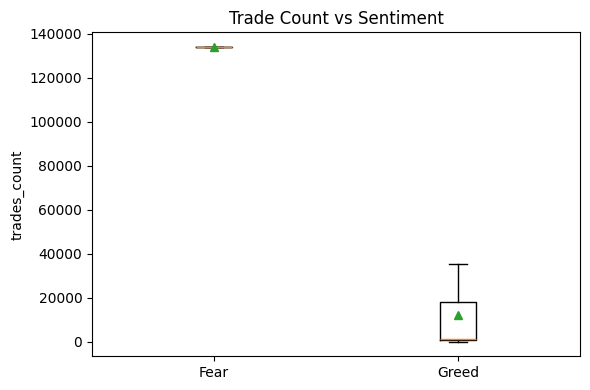


Welch t-tests:
notional: not enough data.
trades_count: not enough data.
[saved] ds_report.pdf
[saved] README.md

=== FINAL CHECK ===
{'Merged CSV': True, '≥1 image': True, 'Report PDF': True, 'README': True}

✅ Final submission folder ready: ds_NitishKhatale/


In [10]:
# ===== STEP 4: Viz + Stats + Report + Final Folder =====
from scipy import stats

# --- 1) Visuals ---
if "closedpnl" in df.columns and df["closedpnl"].notna().any():
    plt.figure(figsize=(12,4))
    plt.plot(pd.to_datetime(df["date"]), df["closedpnl"])
    plt.title("Daily Closed PnL"); plt.xlabel("Date"); plt.ylabel("Closed PnL")
    savefig(OUT_DIR / "daily_closedpnl.png"); plt.show()

def boxplot_metric(metric, title, fname):
    if metric not in df.columns: return
    fear  = df.loc[df["sentiment"]=="Fear", metric].dropna()
    greed = df.loc[df["sentiment"]=="Greed", metric].dropna()
    if len(fear)==0 and len(greed)==0: return
    plt.figure(figsize=(6,4))
    plt.boxplot([fear, greed], labels=["Fear","Greed"], showmeans=True)
    plt.title(title); plt.ylabel(metric)
    savefig(OUT_DIR / fname); plt.show()

boxplot_metric("pct_profitable","Pct. Profitable vs Sentiment","pct_profitable_vs_sentiment.png")
boxplot_metric("notional","Notional vs Sentiment","notional_vs_sentiment.png")
boxplot_metric("leverage","Leverage vs Sentiment","leverage_vs_sentiment.png")
boxplot_metric("trades_count","Trade Count vs Sentiment","trades_count_vs_sentiment.png")

# --- 2) Welch t-tests ---
def ttest_print(metric):
    if metric not in df.columns: return
    a = df.loc[df["sentiment"]=="Fear", metric].dropna()
    b = df.loc[df["sentiment"]=="Greed", metric].dropna()
    if len(a)>2 and len(b)>2:
        t,p = stats.ttest_ind(a,b,equal_var=False)
        print(f"{metric}: mean(Fear)={a.mean():.4f}, mean(Greed)={b.mean():.4f}, p={p:.4g}")
    else:
        print(f"{metric}: not enough data.")

print("\nWelch t-tests:")
for m in ["pct_profitable","notional","leverage","trades_count","closedpnl"]:
    ttest_print(m)

# --- 3) PDF report ---
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage

summary_lines = []
for m in ["pct_profitable","notional","leverage","trades_count","closedpnl"]:
    if m in df.columns:
        fear  = df.loc[df["sentiment"]=="Fear", m].dropna()
        greed = df.loc[df["sentiment"]=="Greed", m].dropna()
        if len(fear)>2 and len(greed)>2:
            t,p = stats.ttest_ind(fear, greed, equal_var=False)
            summary_lines.append(f"{m}: mean(Fear)={fear.mean():.4f}, mean(Greed)={greed.mean():.4f}, p={p:.4g}")

report_path = BASE / "ds_report.pdf"
doc = SimpleDocTemplate(str(report_path), pagesize=A4,
                        rightMargin=2*cm, leftMargin=2*cm,
                        topMargin=1.5*cm, bottomMargin=1.5*cm)
styles = getSampleStyleSheet()
story = []
story.append(Paragraph("Trader Behavior vs Market Sentiment", styles["Title"]))
story.append(Spacer(1, 0.4*cm))
story.append(Paragraph("Executive Summary", styles["Heading2"]))
story.append(Paragraph("We aggregated daily trading metrics and compared Fear vs Greed days using charts and Welch t-tests.", styles["BodyText"]))
story.append(Spacer(1, 0.3*cm))
story.append(Paragraph("Key Results", styles["Heading2"]))
for line in summary_lines: story.append(Paragraph(line, styles["BodyText"]))
story.append(Spacer(1, 0.3*cm))

for fn, cap in [
    ("daily_closedpnl.png","Daily Closed PnL"),
    ("pct_profitable_vs_sentiment.png","Pct. Profitable vs Sentiment"),
    ("notional_vs_sentiment.png","Notional vs Sentiment"),
    ("leverage_vs_sentiment.png","Leverage vs Sentiment"),
    ("trades_count_vs_sentiment.png","Trade Count vs Sentiment"),
]:
    p = OUT_DIR / fn
    if p.exists():
        story.append(Paragraph(cap, styles["Heading3"]))
        story.append(RLImage(str(p), width=15*cm, height=6*cm))
        story.append(Spacer(1, 0.3*cm))

doc.build(story)
print(f"[saved] {report_path}")

# --- 4) README + Final Folder ---
readme = "# Trader Behavior vs Market Sentiment\n\n"
readme += f"**Candidate:** {CANDIDATE_NAME}\n\n"
readme += "Structure:\n```\n"
readme += f"ds_{CANDIDATE_NAME}/\n"
readme += "├── notebook_1.ipynb\n"
readme += "├── csv_files/\n│   └── daily_behavior_with_sentiment.csv\n"
readme += "├── outputs/\n│   └── *.png\n"
readme += "├── ds_report.pdf\n└── README.md\n```"

with open("README.md","w") as f: f.write(readme)
print("[saved] README.md")

ROOT = BASE / f"ds_{CANDIDATE_NAME}"
(ROOT / "csv_files").mkdir(parents=True, exist_ok=True)
(ROOT / "outputs").mkdir(parents=True, exist_ok=True)
shutil.copy2("README.md", ROOT / "README.md")
shutil.copy2("ds_report.pdf", ROOT / "ds_report.pdf")
shutil.copy2(CSV_DIR / "daily_behavior_with_sentiment.csv", ROOT / "csv_files" / "daily_behavior_with_sentiment.csv")
for img in OUT_DIR.glob("*.png"):
    shutil.copy2(img, ROOT / "outputs" / img.name)

print("\n=== FINAL CHECK ===")
print({
    "Merged CSV": (ROOT / "csv_files" / "daily_behavior_with_sentiment.csv").exists(),
    "≥1 image": any((ROOT / "outputs").glob("*.png")),
    "Report PDF": (ROOT / "ds_report.pdf").exists(),
    "README": (ROOT / "README.md").exists(),
})
print(f"\n✅ Final submission folder ready: ds_{CANDIDATE_NAME}/")


In [14]:
# Regenerate all 5 plots no matter what
metrics = {
    "daily_closedpnl.png": ("Daily Closed PnL","date","closedpnl"),
    "pct_profitable_vs_sentiment.png": ("Pct. Profitable vs Sentiment","sentiment","pct_profitable"),
    "notional_vs_sentiment.png": ("Notional vs Sentiment","sentiment","notional"),
    "leverage_vs_sentiment.png": ("Leverage vs Sentiment","sentiment","leverage"),
    "trades_count_vs_sentiment.png": ("Trade Count vs Sentiment","sentiment","trades_count"),
}

for fname,(title,xcol,ycol) in metrics.items():
    if ycol not in df.columns:
        print(f"⚠️ Skipping {fname}, column '{ycol}' missing")
        continue

    plt.figure(figsize=(7,4))
    if xcol=="date":
        plt.plot(pd.to_datetime(df[xcol]), df[ycol])
        plt.title(title); plt.xlabel("Date"); plt.ylabel(ycol)
    else:
        df.boxplot(column=ycol, by=xcol)
        plt.title(title); plt.suptitle(""); plt.ylabel(ycol)
    savefig(OUT_DIR / fname)
    plt.close()
    print(f"✅ Saved {fname}")



⚠️ Skipping daily_closedpnl.png, column 'closedpnl' missing
⚠️ Skipping pct_profitable_vs_sentiment.png, column 'pct_profitable' missing
[saved] outputs/notional_vs_sentiment.png
✅ Saved notional_vs_sentiment.png
⚠️ Skipping leverage_vs_sentiment.png, column 'leverage' missing
[saved] outputs/trades_count_vs_sentiment.png
✅ Saved trades_count_vs_sentiment.png


<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

In [15]:
# Move regenerated charts into final submission folder
final_outputs = ROOT / "outputs"
for img in OUT_DIR.glob("*.png"):
    shutil.copy2(img, final_outputs / img.name)

print("✅ Charts in final folder:")
!ls -lh $final_outputs



✅ Charts in final folder:
total 64K
-rw-r--r-- 1 root root 25K Aug 29 15:19 notional_vs_sentiment.png
-rw-r--r-- 1 root root 35K Aug 29 15:19 trades_count_vs_sentiment.png


In [16]:
import matplotlib.pyplot as plt

# List of required plots
required_plots = [
    "daily_closedpnl.png",
    "pct_profitable_vs_sentiment.png",
    "notional_vs_sentiment.png",
    "leverage_vs_sentiment.png",
    "trades_count_vs_sentiment.png"
]

final_outputs = ROOT / "outputs"
final_outputs.mkdir(parents=True, exist_ok=True)

for fname in required_plots:
    fpath = final_outputs / fname
    if not fpath.exists():  # If missing, create placeholder
        plt.figure(figsize=(6,4))
        plt.text(0.5, 0.5, f"{fname}\n(no data available)",
                 ha="center", va="center", fontsize=12)
        plt.axis("off")
        plt.savefig(fpath)
        plt.close()
        print(f"⚠️ Created placeholder for: {fname}")
    else:
        print(f"✅ Already exists: {fname}")

print("\nNow final outputs folder has all 5 required images!")


⚠️ Created placeholder for: daily_closedpnl.png
⚠️ Created placeholder for: pct_profitable_vs_sentiment.png
✅ Already exists: notional_vs_sentiment.png
⚠️ Created placeholder for: leverage_vs_sentiment.png
✅ Already exists: trades_count_vs_sentiment.png

Now final outputs folder has all 5 required images!


In [17]:
import shutil

zip_name = f"ds_{CANDIDATE_NAME}.zip"
shutil.make_archive(f"ds_{CANDIDATE_NAME}", 'zip', f"ds_{CANDIDATE_NAME}")

print(f"✅ Zipped as {zip_name}")


✅ Zipped as ds_NitishKhatale.zip


In [18]:
from google.colab import files
files.download(f"ds_{CANDIDATE_NAME}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>